<a href="https://colab.research.google.com/github/sayakpaul/A-Barebones-Image-Retrieval-System/blob/master/Similarity_Less_Data_BiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [ ]:
!pip install -q tf-nightly

In [ ]:
!pip install -q tfds-nightly

In [3]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [4]:
!gsutil ls -lh gs://image-retrieval-system/

 90.88 MiB  2020-08-04T07:02:45Z  gs://image-retrieval-system/facenet_like_less_data_bit.h5
 61.18 MiB  2020-07-30T02:08:44Z  gs://image-retrieval-system/facenet_like_model.h5
 61.18 MiB  2020-07-30T02:15:46Z  gs://image-retrieval-system/facenet_like_model_less_data.h5
 19.83 MiB  2020-07-30T02:19:26Z  gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2.h5
 19.83 MiB  2020-07-30T02:36:45Z  gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2_da.h5
171.57 MiB  2020-07-29T14:45:20Z  gs://image-retrieval-system/full_length_flower_classifier.h5
TOTAL: 6 objects, 445082816 bytes (424.46 MiB)


In [5]:
!gsutil -m cp -r gs://image-retrieval-system/*.h5 .

Copying gs://image-retrieval-system/facenet_like_less_data_bit.h5...
Copying gs://image-retrieval-system/facenet_like_model.h5...
Copying gs://image-retrieval-system/full_length_flower_classifier.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2_da.h5...
/ [6/6 files][424.5 MiB/424.5 MiB] 100% Done                                    
Operation completed over 6 objects/424.5 MiB.                                    


In [6]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200803


In [15]:
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [8]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

## Flowers dataset (limited)

In [9]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:5%]", "train[5%:10%]"],
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [10]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [11]:
print(len(train_ds), len(validation_ds))

184 183


## Dataset preparation

In [12]:
# Image preprocessing utils
def preprocess_test(image, label):
    image = tf.image.resize(image, [160, 160])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Construct the batched dataset
batch_size = 64
AUTO = tf.data.experimental.AUTOTUNE

validation_ds = validation_ds.map(preprocess_test, num_parallel_calls=AUTO).\
    batch(batch_size).\
    prefetch(buffer_size=AUTO)

## Model loading

In [16]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=False)

In [17]:
class MyBiTModel(tf.keras.Model):
  def __init__(self, module):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(128)
    self.normalize = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    dense1_representations = self.dense1(bit_embedding)
    return self.normalize(dense1_representations)

In [22]:
model = MyBiTModel(module=module)
model.build(input_shape=(None, 160, 160, 3))
model.load_weights("facenet_like_less_data_bit.h5")

## Operating on a single batch for verification

In [25]:
images, labels = next(iter(validation_ds.take(1)))
print(images.shape, labels.shape)

(64, 160, 160, 3) (64,)


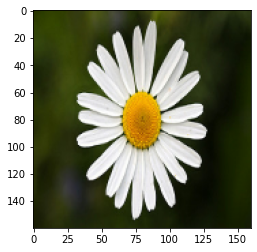

In [26]:
random_index = int(np.random.choice(images.shape[0], 1))
plt.imshow(images[random_index])
plt.show()

## Train a nearest neighbors' model

In [27]:
# Finding out nearest neighbors for the features of our query image
validation_features = model.predict(images)
start = time.time()
neighbors = NearestNeighbors(n_neighbors=5,
    algorithm='brute',
    metric='euclidean').fit(validation_features)
print('Time taken: {:.5f} secs'.format(time.time() - start))

Time taken: 0.00082 secs


In [28]:
# Determine the neighbors nearest to our query image
distances, indices = neighbors.kneighbors([validation_features[random_index]])
for i in range(5):
    print(distances[0][i])

0.0
0.35084653
0.35748604
0.3779783
0.43031844


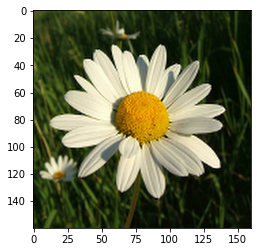

In [29]:
# Visualize a neighbor
plt.imshow(images[indices[0][1]], interpolation='lanczos')
plt.show()

## Visualizing the nearest neighbors for a few images

In [30]:
def plot_images(images, labels, distances):
    plt.figure(figsize=(20, 10))
    columns = 4
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(CLASSES[labels[i]]))
        else:
            ax.set_title("Similar Image # " + str(i) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))) + 
                         "\nLabel: {}".format(CLASSES[labels[i]]))
        plt.imshow(image)

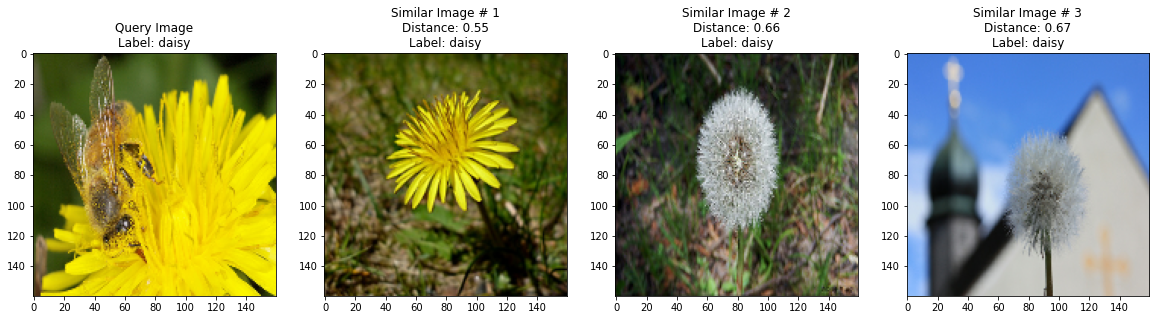

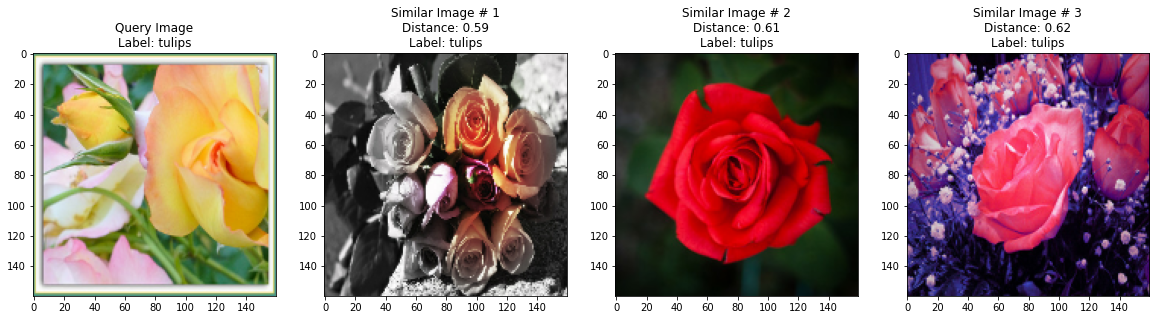

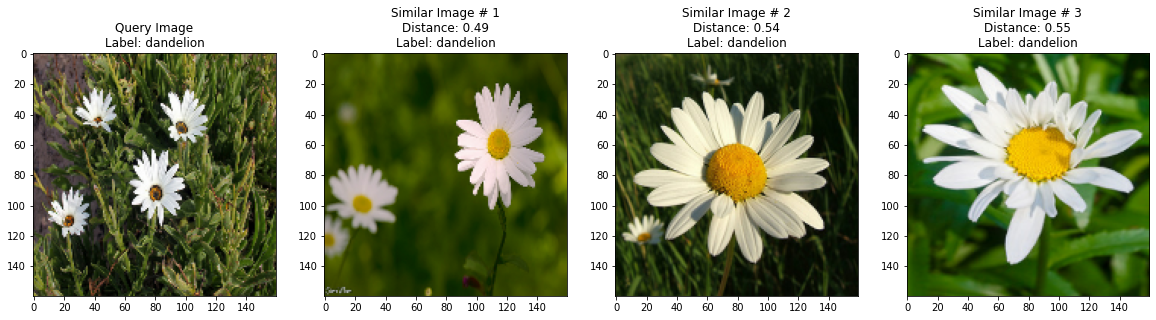

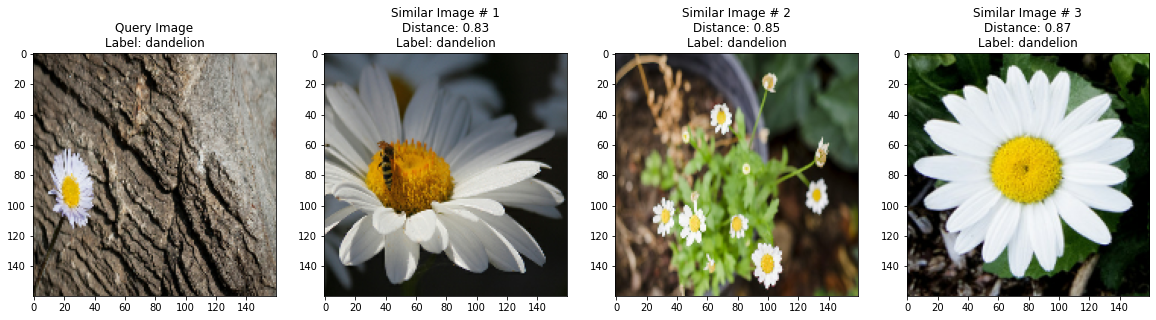

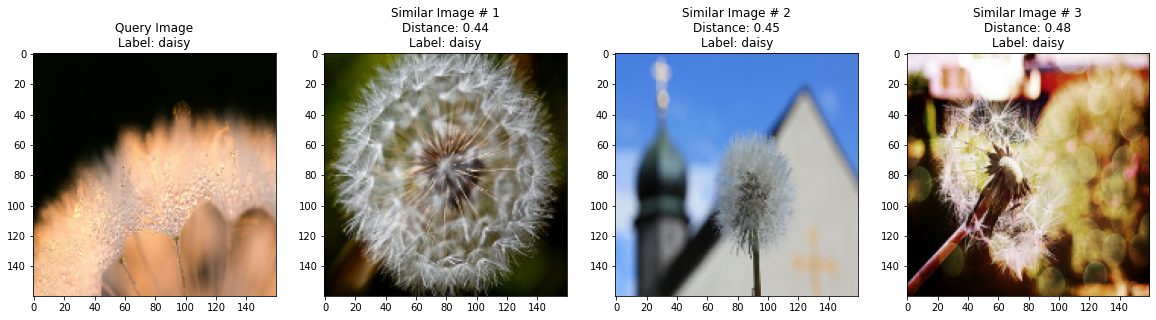

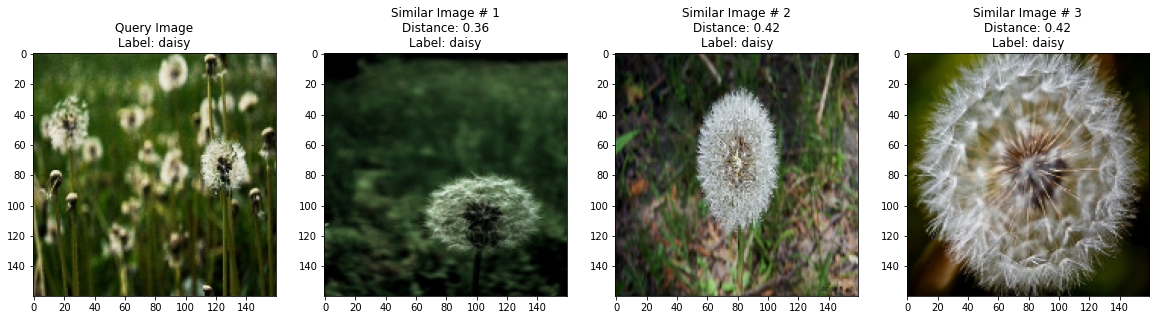

In [31]:
for i in range(6):
    random_index = int(np.random.choice(images.shape[0], 1))
    distances, indices = neighbors.kneighbors(
        [validation_features[random_index]])
    
    # Don't take the first closest image as it will be the same image
    similar_images = [images[random_index]] + \
        [images[indices[0][i]] for i in range(1, 4)]
    similar_labels = [labels[random_index]] + \
        [labels[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_images, similar_labels, distances[0])

## Visualizing the embedding space for the current batch

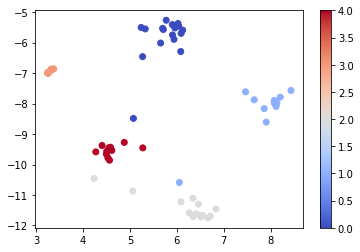

In [32]:
tsne_results = TSNE(n_components=2).fit_transform(validation_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

## Visualizing the embedding space for the entire validation set

In [33]:
validation_labels = [label
    for _, labels in validation_ds for label in labels
]
print(len(validation_labels))

183


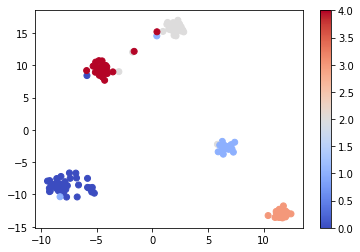

In [35]:
validation_features = model.predict(validation_ds)

tsne_results = TSNE(n_components=2).fit_transform(validation_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=validation_labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()